# Statistical Machine Learning Final Project: Customer Churn Prediction 🏦
### Authors: Sam Strickler, Ava Knight, Taylor, 

# ML Final Project: Customer Churn

**Goal:** Predict whether a bank customer will churn (close their account) and understand which features drive churn.  
**Data:** `customer_churn.csv` (10,000 customers, binary `churn` variable, mix of numeric + categorical predictors).  
**Task type:** Binary classification

## Imports & Exploratory Data Analysis: Ava

Rows: 10,000
Columns: 12
$ customer_id      <dbl> 15634602, 15647311, 15619304, 15701354, 15737888, 15574012, 15592531, 15656148, 15792365, 15592389, 15767821, 15737173, 15632264, 15691483, 15600882, 15643…
$ credit_score     <dbl> 619, 608, 502, 699, 850, 645, 822, 376, 501, 684, 528, 497, 476, 549, 635, 616, 653, 549, 587, 726, 732, 636, 510, 669, 846, 577, 756, 571, 574, 411, 591, …
$ country          <chr> "France", "Spain", "France", "France", "Spain", "Spain", "France", "Germany", "France", "France", "France", "Spain", "France", "France", "Spain", "Germany"…
$ gender           <chr> "Female", "Female", "Female", "Female", "Female", "Male", "Male", "Female", "Male", "Male", "Male", "Male", "Female", "Female", "Female", "Male", "Male", "…
$ age              <dbl> 42, 41, 42, 39, 43, 44, 50, 29, 44, 27, 31, 24, 34, 25, 35, 45, 58, 24, 45, 24, 41, 32, 38, 46, 38, 25, 36, 44, 43, 29, 39, 36, 41, 42, 29, 45, 31, 33, 36,…
$ tenure           <dbl> 2, 1, 8, 1, 2, 8, 7, 4, 4, 2, 6, 3, 10, 

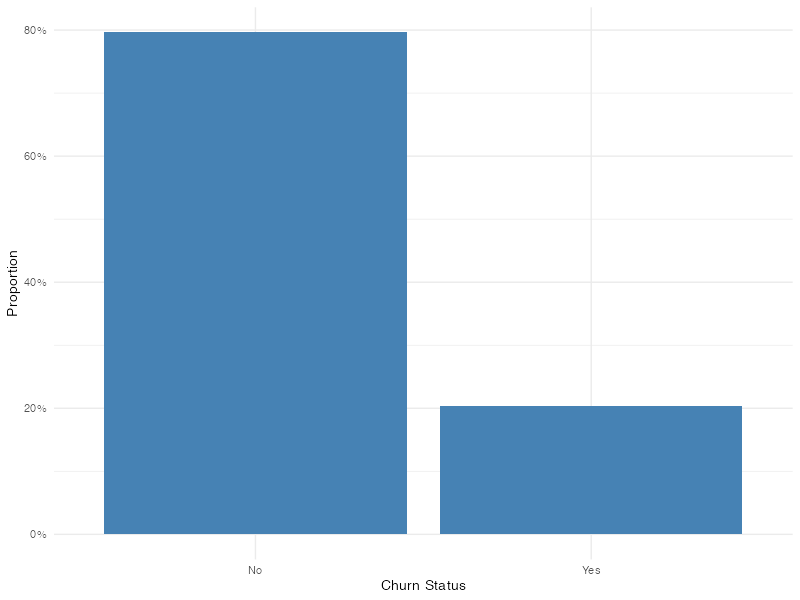

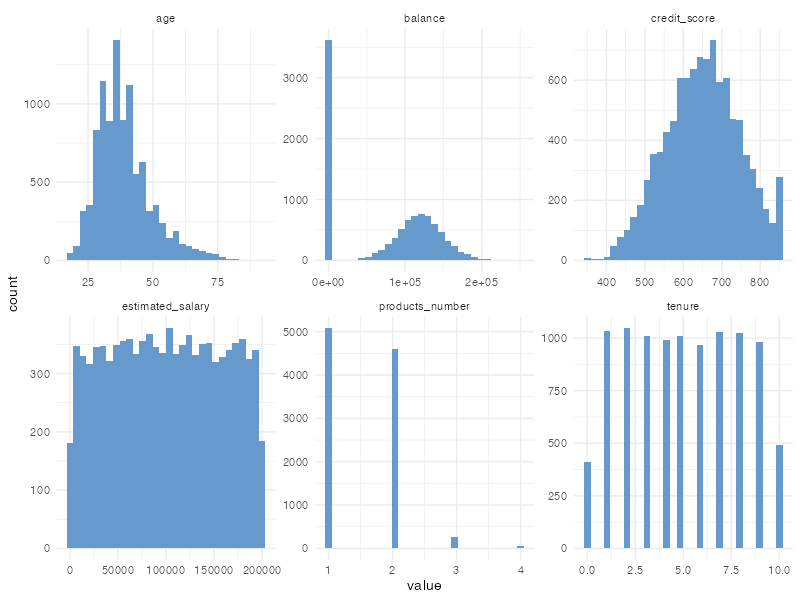

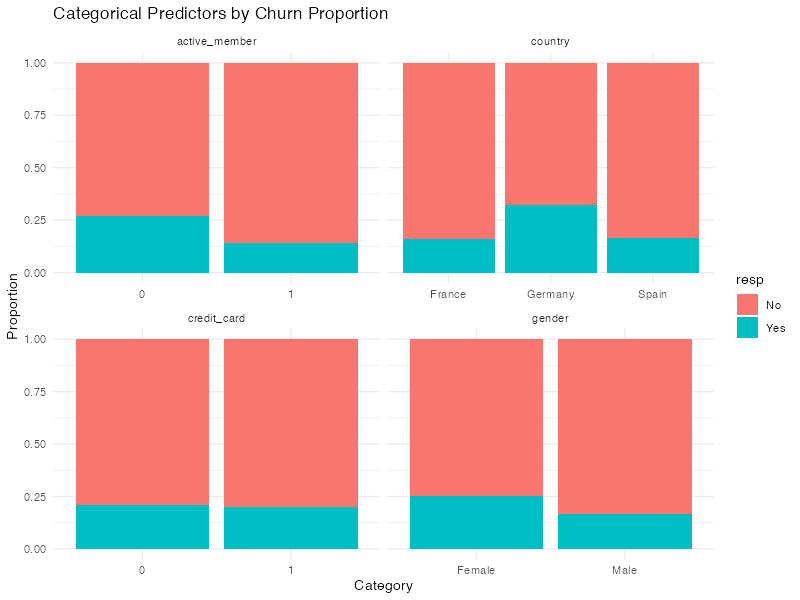

                 credit_score   age tenure balance products_number estimated_salary
credit_score             1.00  0.00   0.00    0.01            0.01             0.00
age                      0.00  1.00  -0.01    0.03           -0.03            -0.01
tenure                   0.00 -0.01   1.00   -0.01            0.01             0.01
balance                  0.01  0.03  -0.01    1.00           -0.30             0.01
products_number          0.01 -0.03   0.01   -0.30            1.00             0.01
estimated_salary         0.00 -0.01   0.01    0.01            0.01             1.00

In [35]:
# MACHINE LEARNING PROJECT — EDA + PREPROCESSING ONLY
# NOTE: No CreateCV() here. No modeling yet.
# We only explore, clean, and define recipes for later use.

# 1. Load Libraries
packages <- c("tidyverse", "caret", "recipes", "janitor", "pROC")
to_install <- packages[!packages %in% installed.packages()[, "Package"]]
if (length(to_install)) install.packages(to_install, repos = "https://cloud.r-project.org")

lapply(packages, library, character.only = TRUE)

# 2. Import Dataset + Clean Names
data <- read_csv(
  "https://raw.githubusercontent.com/samstrc/StatML-Final-Proj/refs/heads/main/customer_churn.csv",
  show_col_types = FALSE
) %>%
  janitor::clean_names()

glimpse(data)
summary(data)
names(data)

# 3. Drop ID Column
df <- data %>%
  select(-customer_id)

# 4. Convert categoricals to factors, rename churn → resp, and move resp to first column
df <- df %>%
  mutate(
    resp          = factor(churn, levels = c(0, 1), labels = c("No", "Yes")),
    country       = factor(country),
    gender        = factor(gender),
    credit_card   = factor(credit_card),    
    active_member = factor(active_member)    
  ) %>%
  select(resp, everything(), -churn)

table(df$resp)

# 5. BASIC EDA
# Missing values
colSums(is.na(df))

# Check class imbalance ------------
ggplot(df, aes(x = resp)) +
  geom_bar(aes(y = after_stat(count/sum(count))), fill = "steelblue") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(y = "Proportion", x = "Churn Status") +
  theme_minimal()

table(df$resp)
prop.table(table(df$resp))

# Numeric Histograms ------------------
df %>%
  select(where(is.numeric)) %>%
  pivot_longer(cols = everything(),
               names_to = "variable",
               values_to = "value") %>%
  ggplot(aes(value)) +
  geom_histogram(bins = 30, fill = "#6699CC") +
  facet_wrap(~ variable, scales = "free") +
  theme_minimal()


# Barplots for categorical predictors -----------------------
df %>%
  select(country, gender, credit_card, active_member, resp) %>%
  mutate(
    credit_card   = factor(credit_card),
    active_member = factor(active_member)
  ) %>%
  pivot_longer(
    cols = -resp,
    names_to = "variable",
    values_to = "value"
  ) %>%
  ggplot(aes(x = value, fill = resp)) +
  geom_bar(position = "fill") +
  facet_wrap(~ variable, scales = "free_x") +
  labs(
    y = "Proportion",
    x = "Category",
    title = "Categorical Predictors by Churn Proportion"
  ) +
  theme_minimal()

# Correlation Matrix for Numeric Predictors ----------------------
numeric_df <- df %>% select(where(is.numeric))
round(cor(numeric_df), 2)

### EDA Summary
The dataset is heavily imbalanced with approximately 80% non-churners and 20% churners. Predictor distributions vary widely: credit score is roughly normal, age is skewed slightly older, and estimated salary is uniform. Several predictors such as balance and products_number show noticeably skewed distributions and spikes at zero. Correlations among numeric variables are generally weak, suggesting little multicollinearity. Binary predictors (credit_card and active_member) differ modestly by churn status, with active_member showing a stronger association.

## Preprocessing Pipeline: Ava

In [36]:
# DEFINE PREPROCESSING RECIPES

# SVM / Logistic Regression recipe
rec_svm <- recipe(resp ~ ., data = df) %>%
  step_zv(all_predictors()) %>%                   
  step_dummy(all_nominal_predictors(), one_hot = TRUE) %>% 
  step_center(all_numeric_predictors()) %>%
  step_scale(all_numeric_predictors())

# Decision tree recipe (for your teammates later)
rec_tree <- recipe(resp ~ ., data = df) %>%
  step_impute_mode(all_nominal_predictors()) %>%
  step_impute_median(all_numeric_predictors())

# IMPORTANT:
# Do NOT prep() or bake() here before CV!


In [37]:
# 5. CREATE CROSS-VALIDATION FOLDS
source("https://nmimoto.github.io/R/ML-00.txt")

set.seed(1234)
cv <- CreateCV(df, numFolds = 5, seed = 1234)



    number of folds:  5 
    number of obs:  10000 
    training data:  1666  x  5  =  8330 
    size of test data:  1670 

    Global variables created:  
      Train.set       Train.resp           
      Test.set        Test.resp            
      CV.train[[k]]   CV.train.resp[[k]]   
      CV.valid[[k]]   CV.valid.resp[[k]]  



## SVM Modeling: Sam

In [38]:
# 6. TRAIN SVM USING 5-FOLD CV
svm_results <- list()
all_probs <- c()
all_true  <- c()

for (k in 1:5) {
  
  # Build training & validation frames
  train_data <- data.frame(resp = CV.train.resp[[k]], CV.train[[k]])
  test_data  <- data.frame(resp = CV.valid.resp[[k]], CV.valid[[k]])
  
  # Ensure correct factor types
  train_data$resp <- factor(train_data$resp, levels = c("No", "Yes"))
  test_data$resp  <- factor(test_data$resp, levels = c("No", "Yes"))

  fact_cols <- c("country", "gender", "credit_card", "active_member")
  train_data[fact_cols] <- lapply(train_data[fact_cols], factor)
  test_data[fact_cols]  <- lapply(test_data[fact_cols], factor)
  
  # Preprocess **inside the fold**
  prep_svm <- prep(rec_svm, training = train_data)
  train_svm <- bake(prep_svm, train_data)
  test_svm  <- bake(prep_svm, test_data)
  
  # Train SVM
  ctrl <- trainControl(method = "none", classProbs = TRUE)
  svm_model <- train(resp ~ ., data = train_svm, method = "svmRadial", trControl = ctrl)
  
  # Predict
  preds <- predict(svm_model, newdata = test_svm)
  probs <- predict(svm_model, newdata = test_svm, type = "prob")[, "Yes"]
  
  all_probs <- c(all_probs, probs)
  all_true  <- c(all_true,  test_svm$resp)
  
  svm_results[[k]] <- confusionMatrix(preds, test_svm$resp)
}

       Metric      Mean          SD
1    Accuracy 0.8515006 0.003926873
2 Sensitivity 0.9587370 0.005074267
3 Specificity 0.4365166 0.022022315
4    F1 Score 0.9111344 0.003391825


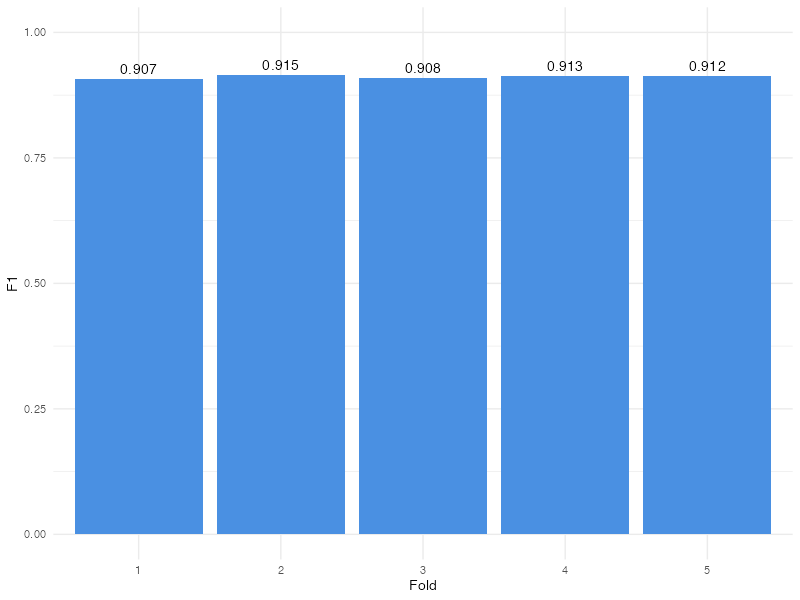

In [39]:
# 7. METRICS & VISUALIZATION

accuracy     <- sapply(svm_results, \(x) x$overall["Accuracy"])
sensitivity  <- sapply(svm_results, \(x) x$byClass["Sensitivity"])
specificity  <- sapply(svm_results, \(x) x$byClass["Specificity"])
f1           <- sapply(svm_results, \(x) x$byClass["F1"])

svm_summary <- data.frame(
  Metric = c("Accuracy", "Sensitivity", "Specificity", "F1 Score"),
  Mean   = c(mean(accuracy), mean(sensitivity), mean(specificity), mean(f1)),
  SD     = c(sd(accuracy), sd(sensitivity), sd(specificity), sd(f1))
)

print(svm_summary)

# ---- F1 plot data
f1_df <- data.frame(Fold = factor(1:5), F1 = f1)

# Bar plot
ggplot(f1_df, aes(x = Fold, y = F1)) +
  geom_col(fill = "#4A90E2") +
  geom_text(aes(label = round(F1, 3)), vjust = -0.5) +
  ylim(0, 1) +
  theme_minimal()

# Combined confusion matrix
overall_cm <- Reduce("+", lapply(svm_results, \(x) x$table))
overall_cm
